In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10)
from scipy import stats
from scipy import optimize
from scipy.stats import norm, chi2, f
from matplotlib import rcParams
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.graphics import regressionplots
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white, het_goldfeldquandt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, metrics
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from statsmodels.imputation import mice
from fitter import Fitter
from sklearn.impute import KNNImputer
from ydata_profiling import ProfileReport
import rpy2.ipython
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 2. Data Description and Exploratory Analysis

In [121]:
data = pd.read_csv('/Users/joshkenworthy/Desktop/lr_data.csv', index_col = 0)
data = data.drop(columns=['Period'])
data_num = data.drop(columns=['Sector','Industry'])
data.head()

Leverage       ROA  Tangibility  Log_Total_Assets  Market_to_Book  \
Ticker                                                                      
AACG    0.086290 -0.031891     0.173849         19.945539        0.731223   
AAOI    0.295913 -0.043313     0.510779         19.831599        3.026282   
AAON    0.069631  0.051061     0.429989         20.753431       10.950511   
AAPL    0.292150  0.040375     0.125158         26.623108       61.560925   
ABAT    0.034974 -0.158393     0.729087         18.117313        1.322380   

        Log_Market_to_Book  Effective_Tax_Rate  Realized_Volatility  Turnover  \
Ticker                                                                          
AACG             -0.313037            0.157516             0.061763  0.000612   
AAOI              1.107335            0.000000             0.074708  0.052413   
AAON              2.393386            0.184000             0.022139  0.005529   
AAPL              4.120027            0.210000             0.014231  0.003626   
ABAT              0.279433            0.000000             0.046674  0.007924   

                    Sector                       Industry  
Ticker                                                     
AACG    Consumer Defensive  Education & Training Services  
AAOI            Technology        Communication Equipment  
AAON           Industrials  Building Products & Equipment  
AAPL            Technology           Consumer Electronics  
ABAT           Industrials               Waste Management

#### (b) Descriptive Statistics

In [122]:
data.describe()

Leverage          ROA  Tangibility  Log_Total_Assets  \
count  2153.000000  2153.000000  2153.000000       2153.000000   
mean      0.201425    -0.046996     0.163128         20.284546   
std       0.200318     0.136023     0.213227          2.398154   
min       0.000000    -2.067602     0.000000         12.951530   
25%       0.034952    -0.068293     0.017744         18.607268   
50%       0.128691    -0.001964     0.077116         20.265605   
75%       0.332162     0.008916     0.206163         21.862133   
max       0.923690     0.852704     0.967618         30.765445   

       Market_to_Book  Log_Market_to_Book  Effective_Tax_Rate  \
count     2153.000000         2153.000000         2153.000000   
mean        15.454245            0.728562            0.142415   
std        249.765129            1.360697            0.108095   
min          0.000038          -10.169906            0.000000   
25%          0.944707           -0.056881            0.000273   
50%          1.829046            0.603794            0.196000   
75%          4.207168            1.436790            0.215000   
max      10381.738730            9.247804            0.400000   

       Realized_Volatility     Turnover  
count          2153.000000  2153.000000  
mean              0.043146     0.024089  
std               0.056025     0.106506  
min               0.000000     0.000000  
25%               0.022912     0.002338  
50%               0.034155     0.005638  
75%               0.050000     0.010638  
max               1.923395     1.623789

#### (c) Visualizations

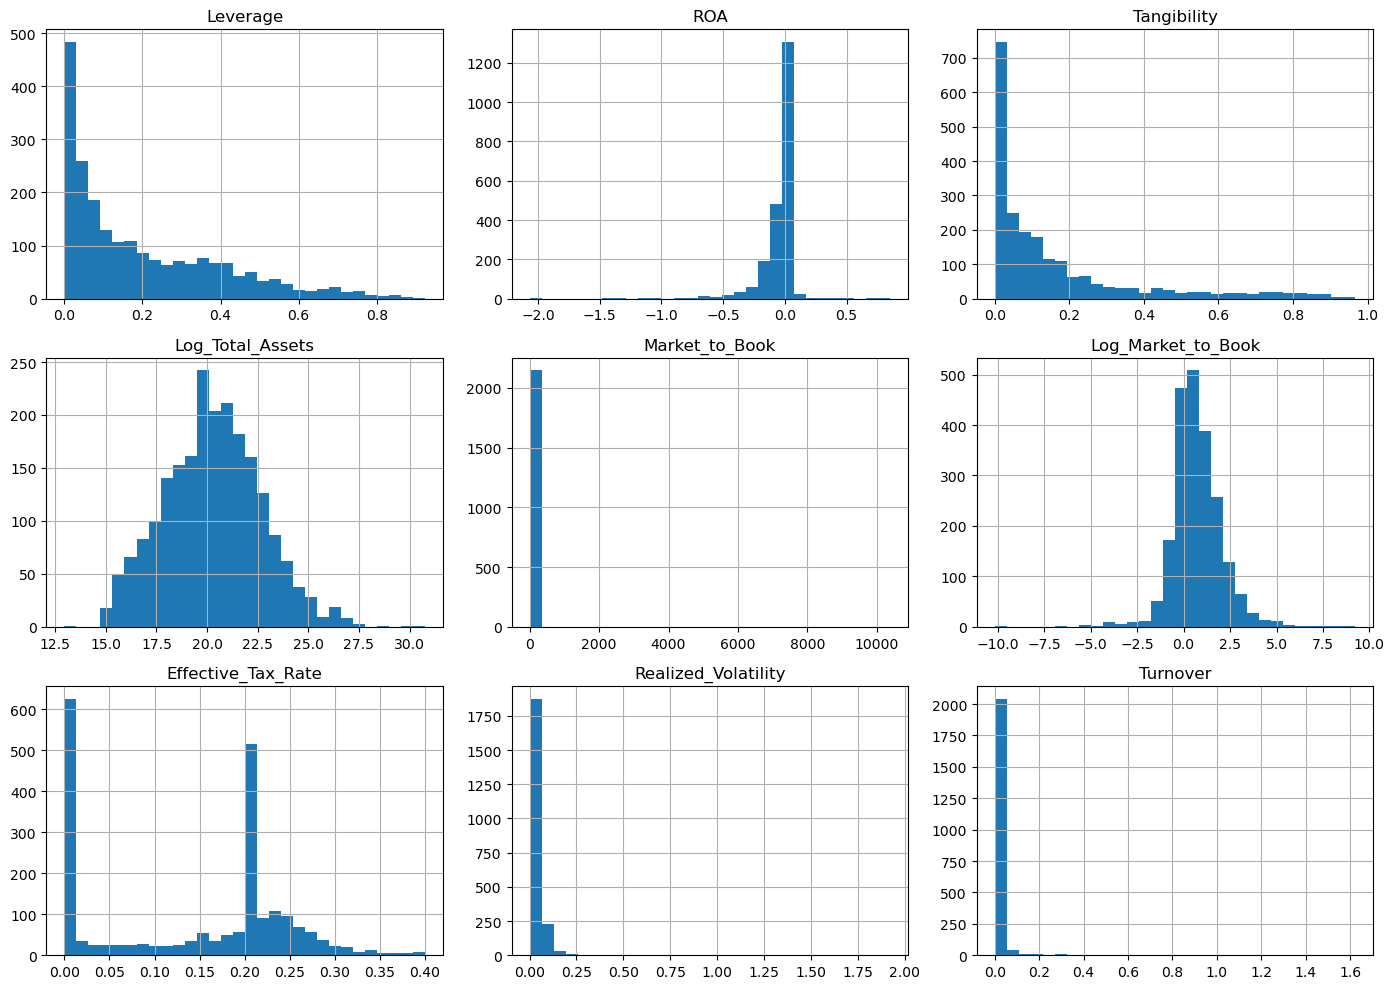

In [123]:
data_num.hist(figsize=(14, 10), bins=30) #histogram of all data
plt.tight_layout()
plt.show()

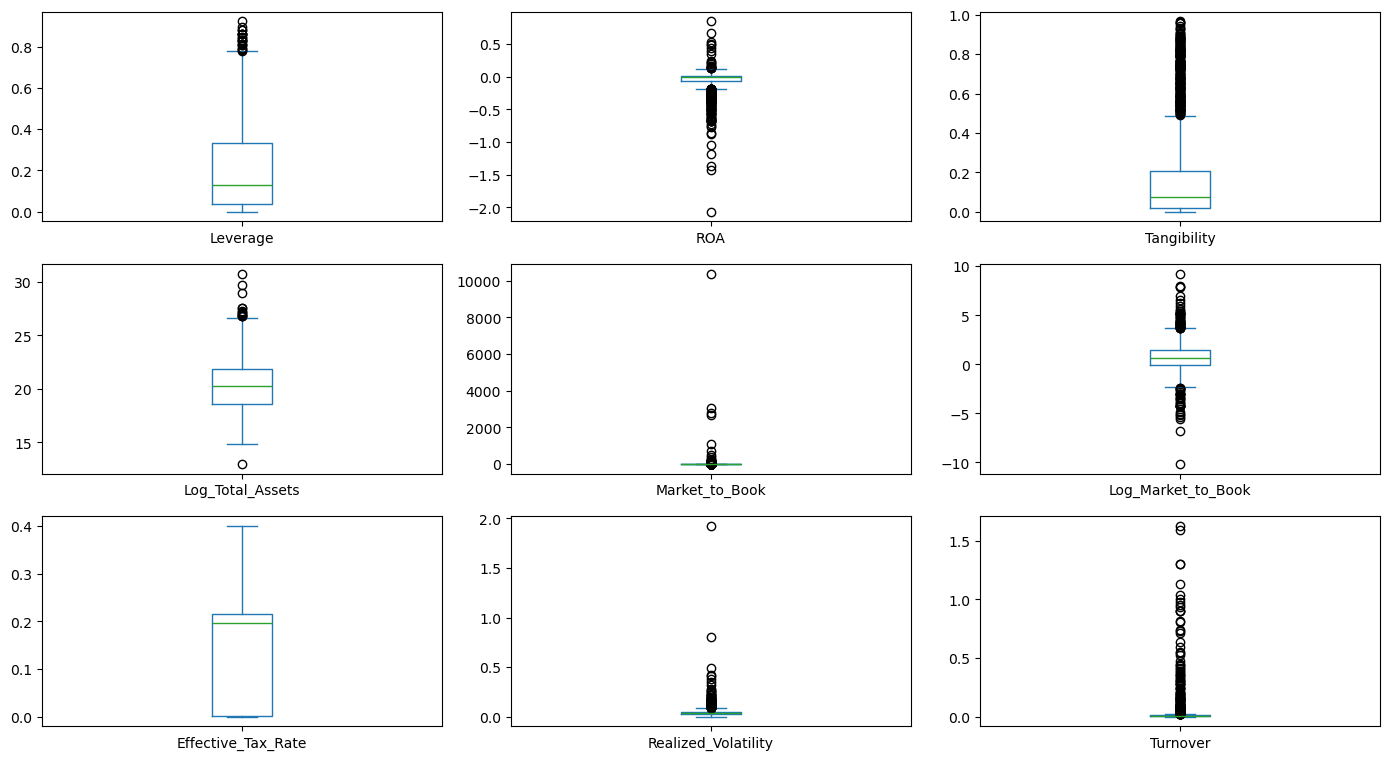

In [124]:
data_num.plot(kind='box', subplots=True, layout=(4, 3), figsize=(14, 10), sharex=False, sharey=False)
plt.tight_layout() #boxplot of all data
plt.title('Variable Box Plots')
plt.show()

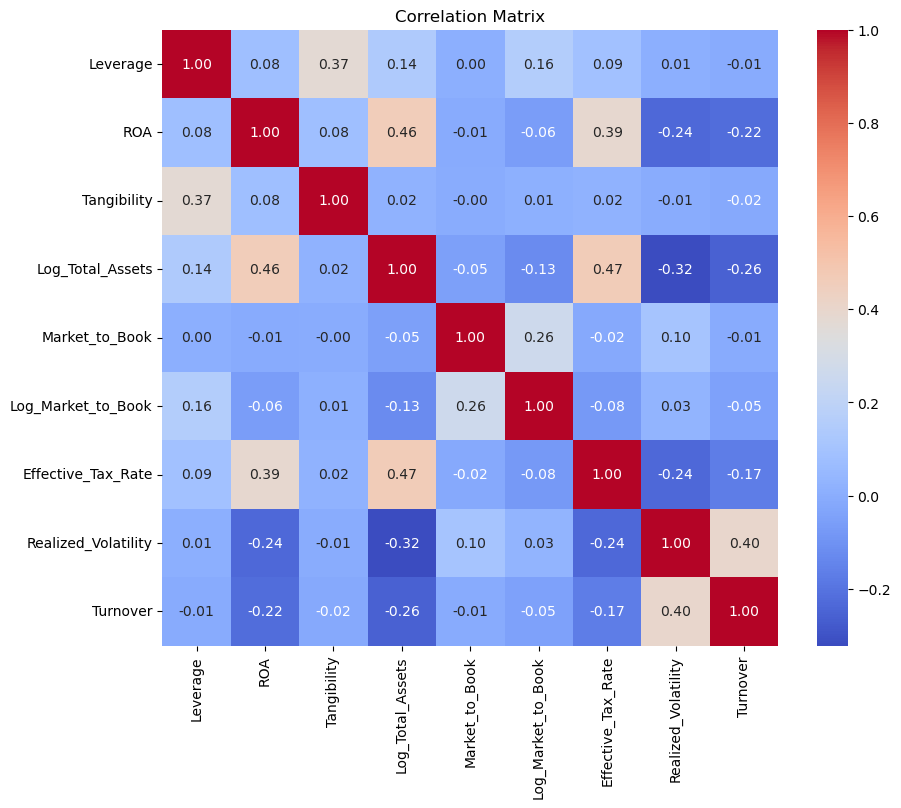

In [125]:
corr = data_num.corr() #correlation matrix for numeric data
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()

<Figure size 640x480 with 0 Axes>

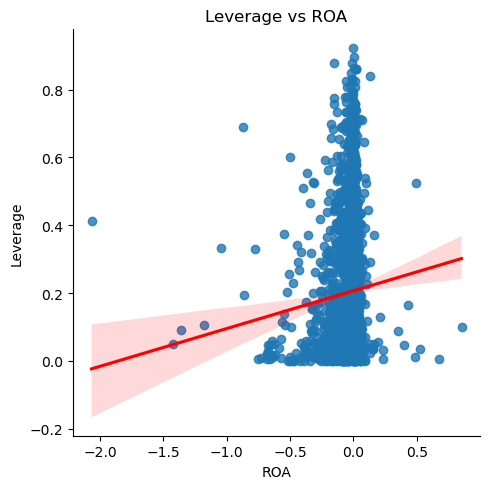

<Figure size 640x480 with 0 Axes>

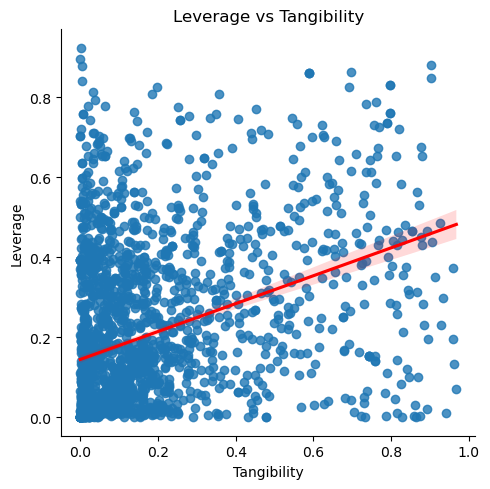

<Figure size 640x480 with 0 Axes>

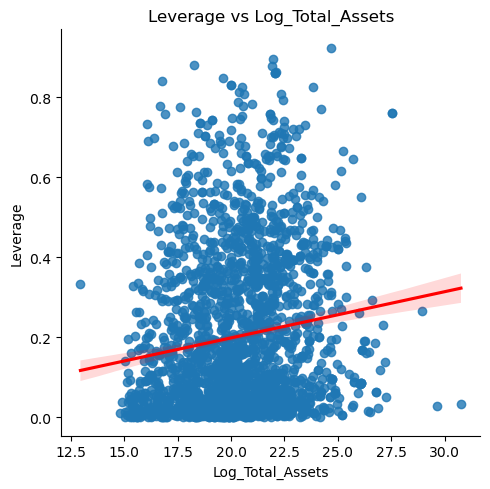

<Figure size 640x480 with 0 Axes>

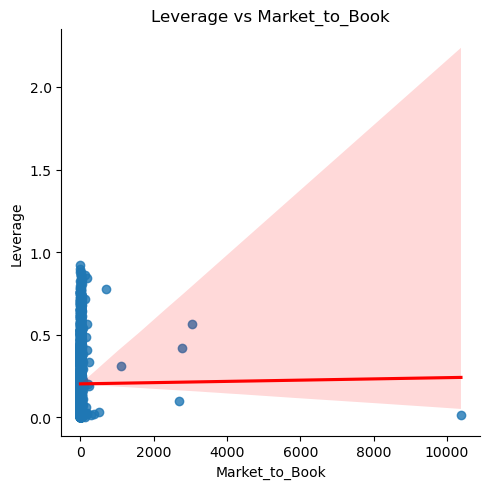

<Figure size 640x480 with 0 Axes>

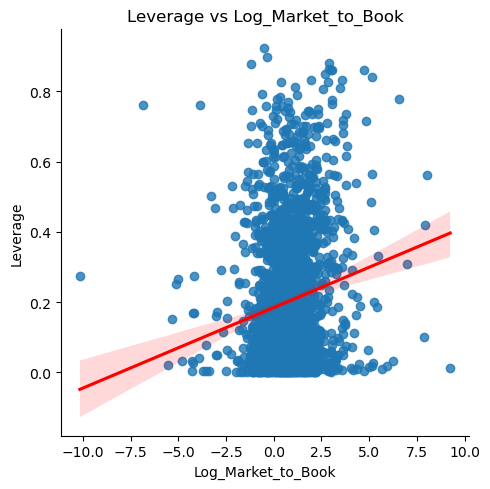

<Figure size 640x480 with 0 Axes>

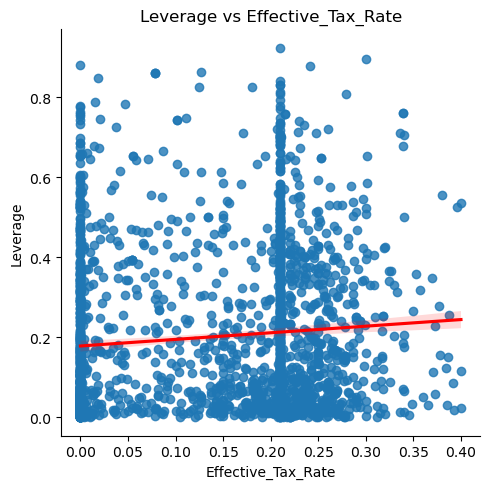

<Figure size 640x480 with 0 Axes>

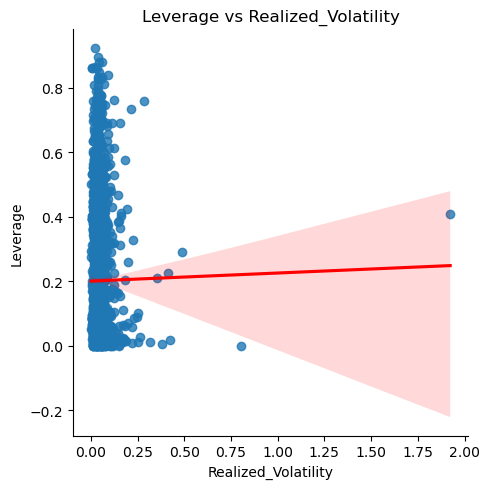

<Figure size 640x480 with 0 Axes>

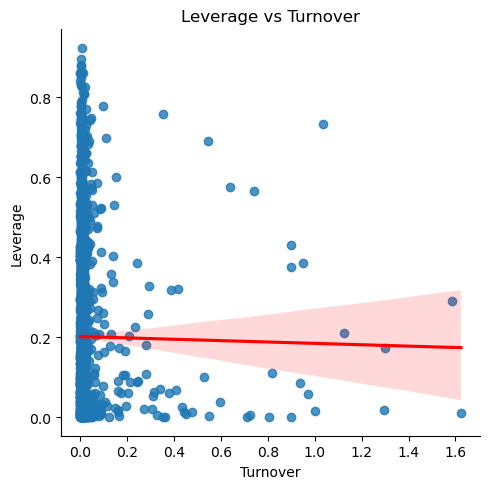

In [126]:
target = 'Leverage' #Scatter plot with smoother of all predictors against leverage
predictors = [col for col in data_num.select_dtypes(include=[np.number]).columns if col != target]

for col in predictors:
    plt.figure()
    sns.lmplot(data=data_num, x=col, y=target, line_kws={'color': 'red'})
    plt.title(f'{target} vs {col}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


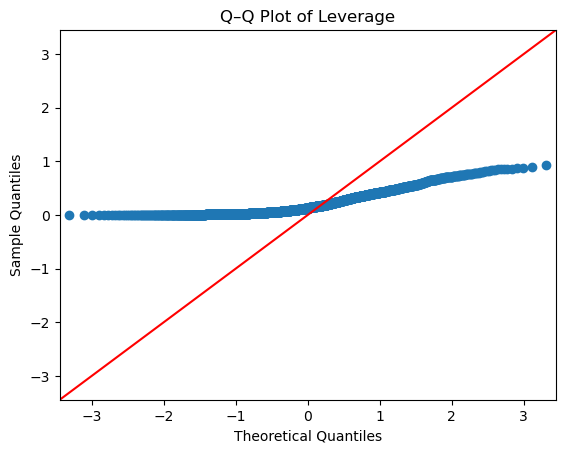

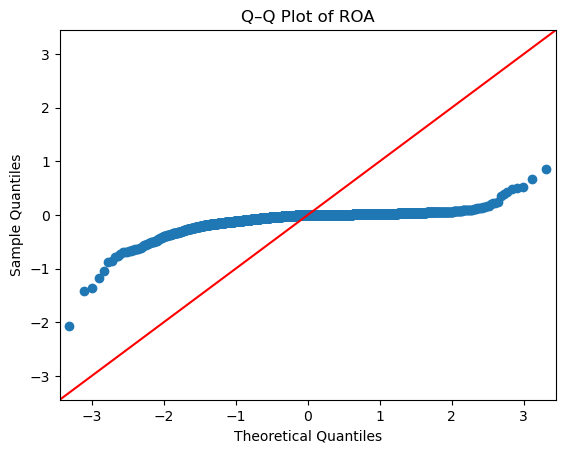

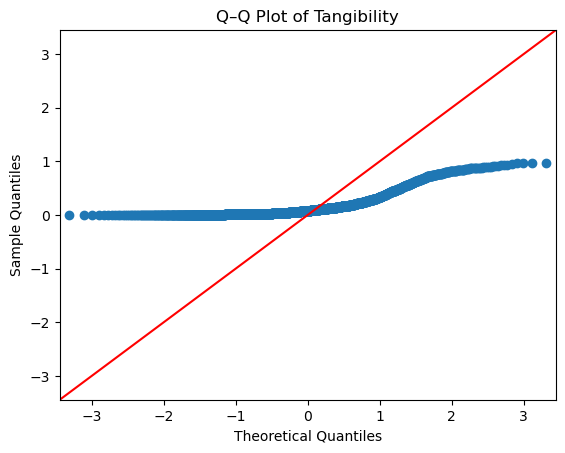

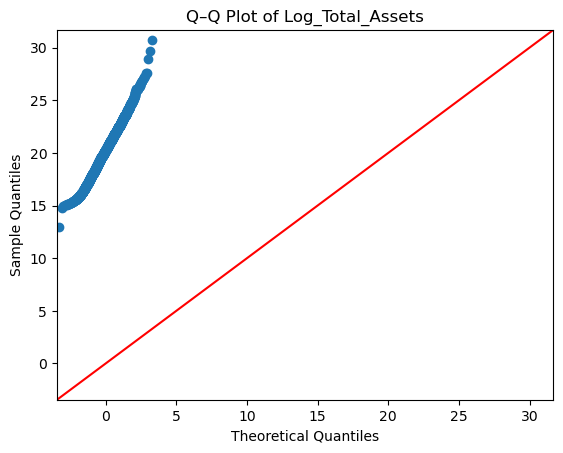

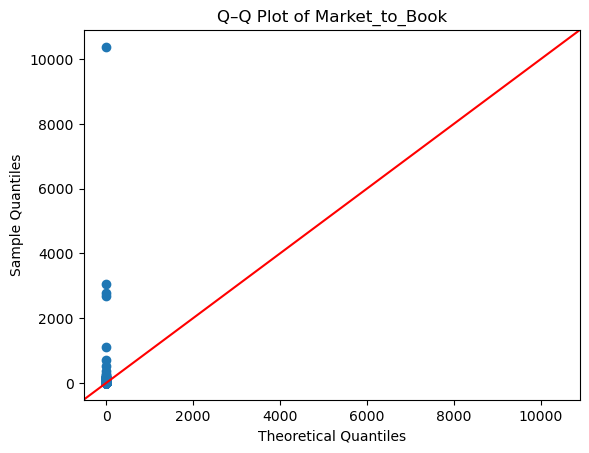

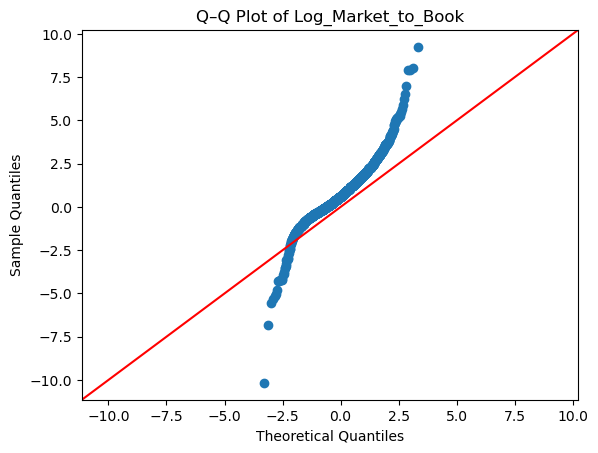

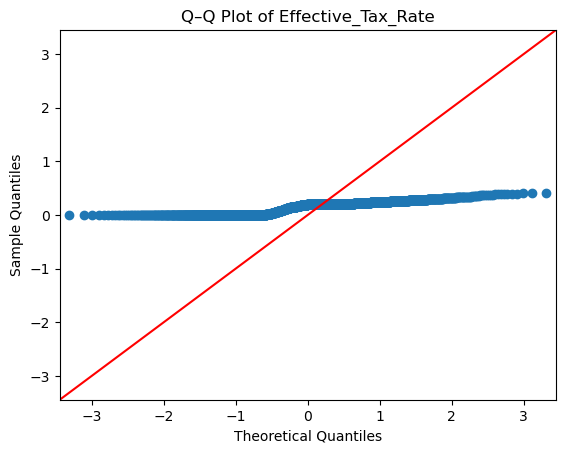

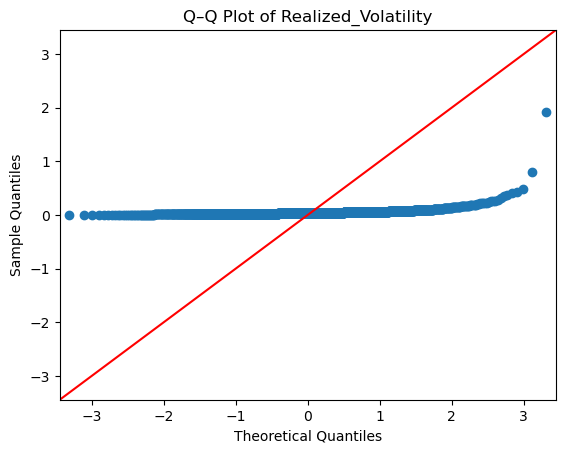

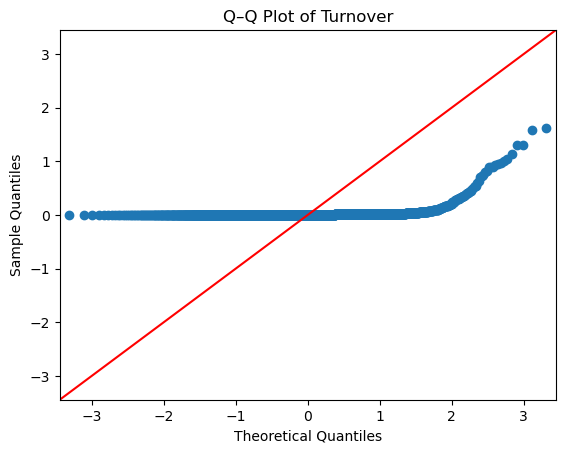

In [127]:
for col in data_num.select_dtypes(include=[np.number]).columns: #qq-plots for all data against Standard Normal
    sm.qqplot(data[col], line='45')
    plt.title(f'Q–Q Plot of {col}')
    plt.show()

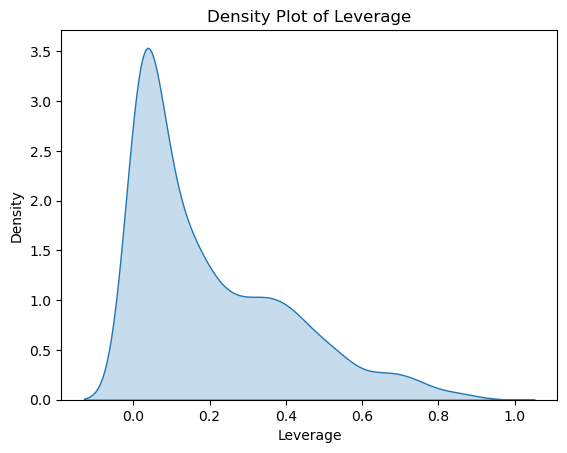

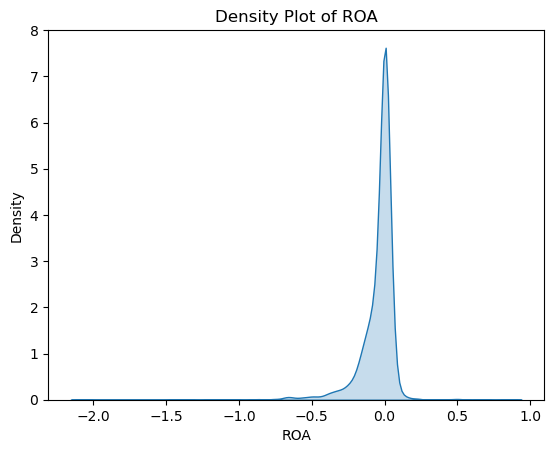

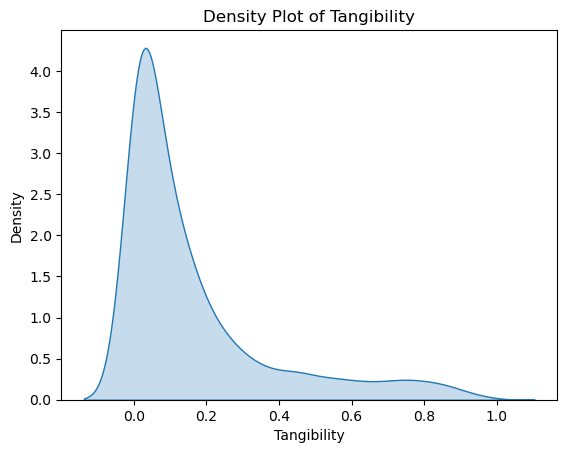

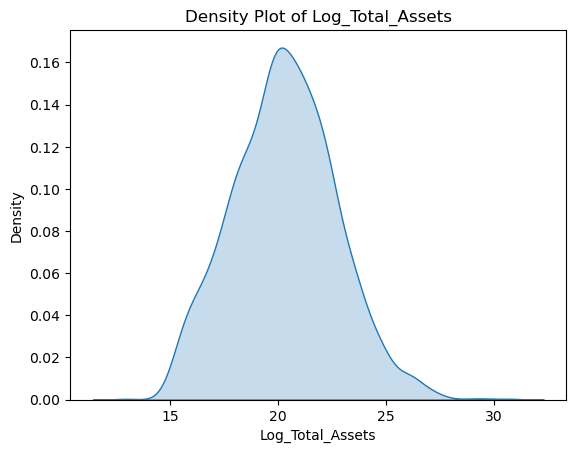

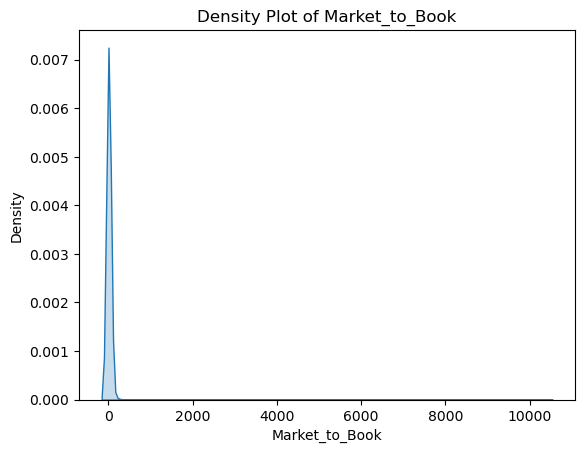

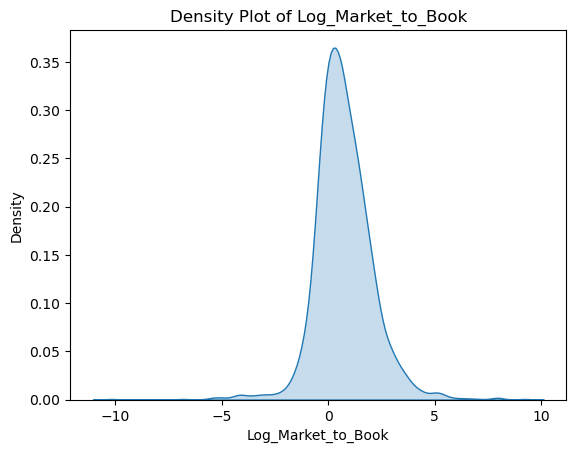

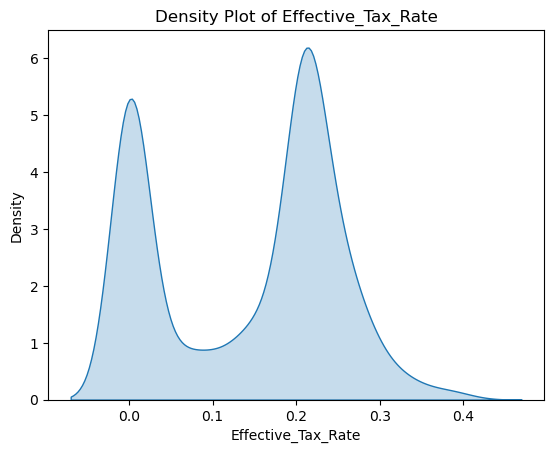

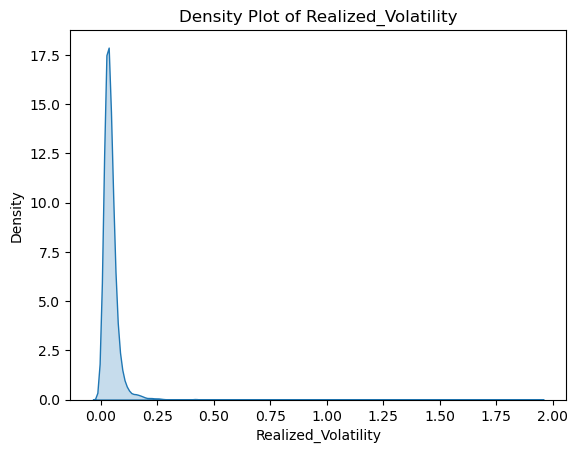

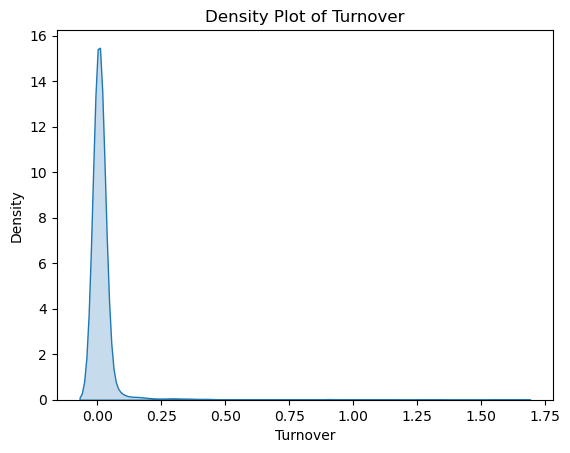

In [128]:
for col in data_num: #density plot for all variables
    plt.figure()
    sns.kdeplot(data[col], fill=True)
    plt.title(f'Density Plot of {col}')
    plt.show()

#### (e) Non-Linearities & Transformations 

Most of are parameters are non-linear and will certainly need transformations. Variables 'Total Assets' and 'Market-to-Book' have already been log transformed and have shown minor improvements. The majority of our data are heavily right skewed and will likely need to undergo log or root transformations in order to conduct proper analysis.

In [129]:
data

Leverage       ROA  Tangibility  Log_Total_Assets  Market_to_Book  \
Ticker                                                                      
AACG    0.086290 -0.031891     0.173849         19.945539        0.731223   
AAOI    0.295913 -0.043313     0.510779         19.831599        3.026282   
AAON    0.069631  0.051061     0.429989         20.753431       10.950511   
AAPL    0.292150  0.040375     0.125158         26.623108       61.560925   
ABAT    0.034974 -0.158393     0.729087         18.117313        1.322380   
...          ...       ...          ...               ...             ...   
ZNTL    0.089773 -0.089109     0.085250         19.926226        0.738944   
ZTEK    0.043438 -0.143231     0.696088         16.872316        3.922127   
ZVRA    0.312851 -0.173453     0.007450         19.070665        5.294509   
ZYME    0.041568 -0.061275     0.073258         20.004087        2.379680   
ZYXI    0.592429  0.018896     0.108513         18.652261        7.262884   

        Log_Market_to_Book  Effective_Tax_Rate  Realized_Volatility  Turnover  \
Ticker                                                                          
AACG             -0.313037            0.157516             0.061763  0.000612   
AAOI              1.107335            0.000000             0.074708  0.052413   
AAON              2.393386            0.184000             0.022139  0.005529   
AAPL              4.120027            0.210000             0.014231  0.003626   
ABAT              0.279433            0.000000             0.046674  0.007924   
...                    ...                 ...                  ...       ...   
ZNTL             -0.302533            0.000672             0.061593  0.025314   
ZTEK              1.366634            0.000000             0.033857  0.000257   
ZVRA              1.666670            0.000000             0.062428  0.019653   
ZYME              0.866966            0.210000             0.022425  0.010449   
ZYXI              1.982777            0.250000             0.032589  0.004578   

                    Sector                        Industry  
Ticker                                                      
AACG    Consumer Defensive   Education & Training Services  
AAOI            Technology         Communication Equipment  
AAON           Industrials   Building Products & Equipment  
AAPL            Technology            Consumer Electronics  
ABAT           Industrials                Waste Management  
...                    ...                             ...  
ZNTL            Healthcare                   Biotechnology  
ZTEK            Healthcare  Medical Instruments & Supplies  
ZVRA            Healthcare                   Biotechnology  
ZYME            Healthcare                   Biotechnology  
ZYXI            Healthcare            Medical Distribution  

[2153 rows x 11 columns]

#### (f) Outlier Detection

In [130]:
reg = smf.ols('Leverage ~ ROA + Tangibility + Log_Total_Assets + Market_to_Book+ Effective_Tax_Rate + Realized_Volatility + Turnover', data = data).fit()

reg.summary() #standard OLS with raw variables (no transform)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Leverage   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     58.09
Date:                Thu, 30 Oct 2025   Prob (F-statistic):           1.63e-76
Time:                        16:04:54   Log-Likelihood:                 594.10
No. Observations:                2153   AIC:                            -1172.
Df Residuals:                    2145   BIC:                            -1127.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.1173      0.042     -2.819      0.005      -0.199      -0.036
ROA                    -0.0233      0.034     -0.686      0.493      -0.090       0.043
Tangibility             0.3473      0.019     18.614      0.000       0.311       0.384
Log_Total_Assets        0.0120      0.002      5.855      0.000       0.008       0.016
Market_to_Book        6.51e-06    1.6e-05      0.407      0.684   -2.49e-05    3.79e-05
Effective_Tax_Rate      0.0666      0.043      1.562      0.118      -0.017       0.150
Realized_Volatility     0.1906      0.080      2.368      0.018       0.033       0.348
Turnover                0.0289      0.041      0.701      0.484      -0.052       0.110
==============================================================================
Omnibus:                      328.904   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              503.030
Skew:                           1.074   Prob(JB):                    5.87e-110
Kurtosis:                       3.997   Cond. No.                     5.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [131]:
out = pd.DataFrame() # new dataframe
out['residuals'] = reg.resid # regression residuals
out['fitted'] = reg.fittedvalues # regression fitted values

influence = reg.get_influence() # regression influence
out['studentized_resid'] = influence.resid_studentized_internal

out['outlier_flag_2'] = (out['studentized_resid'].abs() > 2).astype(int) # boundary flags
out['outlier_flag_3'] = (out['studentized_resid'].abs() > 3).astype(int)
out

residuals    fitted  studentized_resid  outlier_flag_2  outlier_flag_3
Ticker                                                                        
AACG    -0.118234  0.204524          -0.642906               0               0
AAOI    -0.018008  0.313921          -0.098024               0               0
AAON    -0.225986  0.295617          -1.229308               0               0
AAPL     0.031481  0.260669           0.171487               0               0
ABAT    -0.330311  0.365285          -1.799944               0               0
...           ...       ...                ...             ...             ...
ZNTL    -0.075320  0.165093          -0.409731               0               0
ZTEK    -0.292504  0.335942          -1.594004               0               0
ZVRA     0.183056  0.129795           0.995899               0               0
ZYME    -0.125702  0.167270          -0.683611               0               0
ZYXI     0.426481  0.165948           2.320548               1               0

[2153 rows x 5 columns]

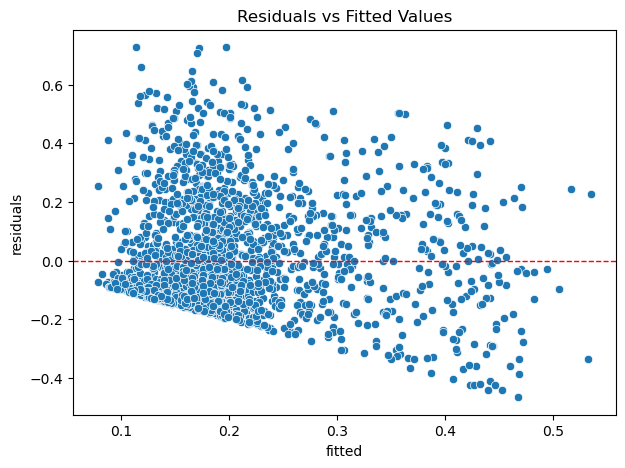

In [132]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='fitted', y='residuals', data=out)
plt.axhline(out['residuals'].mean(), color='red', linestyle='--', linewidth=1)
plt.title('Residuals vs Fitted Values')
plt.show()

In [135]:
Q1 = data['Leverage'].quantile(0.25) #Leverage IQR
Q3 = data['Leverage'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR:.4f}")
print(f"Lower bound: {lower_bound:.4f}")
print(f"Upper bound: {upper_bound:.4f}")

out['Leverage'] = data['Leverage']
out['IQR_flag'] = ((out['Leverage'] < lower_bound) | (out['Leverage'] > upper_bound)).astype(int)

iqr_outliers = out[out['IQR_flag'] == 1]
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

IQR: 0.2972
Lower bound: -0.4109
Upper bound: 0.7780
Number of IQR outliers: 21


**Residuals and IQR**

Our residuals are not normally distributed, nor are they homoskedastic. They do have a mean of zero, complying with the exogeneity assumption. Currently, we are violating two of the major OLS assumptions. We will likely need to transform our variables and use robust standard errors. 

Our IQR states that most 75% of firms' leverage ratios fall between 0.4109 and 0.7780. There are twenty-one observations (roughly 1% of total observations) that were flagged as potential outliers. These firms represent exceptionally high or low leverage ratios, but proportionally, they are very small. This indicates that the overall sample distribution of leverage is stable.

#### (g) Missing Values and Imputation

The way that we have chosen to deal with missing values is to drop the rows where missing observations occur. We chose this approach because we have more than enough observations to make our predictions significant and don't want to risk bias from imputing using methods such as KNN or MICE.

#### (h) Findings

In [138]:
profile = ProfileReport(data, title="Dataset Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 832.38it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Pandas Profiling Takeaways**

The pandas-profiling report produced results consistent with our manual exploratory analysis. The automated summary confirmed a similar number of potential leverage outliers as identified using the IQR method. In addition, the profiling report highlighted strong correlations between leverage ratios and several explanatory variables, including return on assets (ROA), total assets, market-to-book ratio, effective tax rate, and realized volatility. These relationships align with economic expectations, suggesting that firms’ leverage decisions are closely linked to profitability, firm size, valuation, tax position, and market risk.